In [4]:
import matplotlib.pyplot as plt
import jax.numpy as np
import tigercontrol
from tigercontrol.methods.control import ControlMethod
from jax import grad,jit
import jax
from tigercontrol.experiments.core import run_experiment

In [5]:
T = 100

In [6]:
problem_id = "LDS-Control-v0"

n = 3 # dimension of  the state x 
m = 5 # control dimension
d = 3 # hidden/state dimension (which is equal to state dimension here)
noise = 0.2
fully_observable = True

problem_params = {'n': n, 'm' : m, 'd' : d, 'noise' : noise, 'fully_observable' : fully_observable}

In [ ]:
K = np.zeros((m, n))
H, HH = 3, 30

GPC_params = {'A' : problem.A, 'B': problem.B, 'x' : x, 'n' : n, 'm' : m, 'H' : H, 'HH' : HH, 'K':K}

In [6]:
model = GPC()
model.initialize(problem.A, problem.B, x, n, m, 3, 30, K)

In [7]:
GPC_results = []
for i in range(T):
    u = model.plan(x)
    x = problem.step(u)
    GPC_results.append(x)

(3,)


In [8]:
x = problem.initialize(n, m, d, noise = 0.2, fully_observable = True)

/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:58: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


In [9]:
"""
Linear Quadratic Regulator
"""

import jax.numpy as np
import tigercontrol
from tigercontrol.methods.control import ControlMethod

class LQR(ControlMethod):
    """
    Description: Computes optimal set of actions using the Linear Quadratic Regulator
    algorithm.
    """
    
    compatibles = set([])

    def __init__(self):
        self.initialized = False

    def to_ndarray(self, x):
        """
        Description: If x is a scalar, transform it to a (1, 1) numpy.ndarray;
        otherwise, leave it unchanged.
        Args:
            x (float/numpy.ndarray)
        Returns:
            A numpy.ndarray representation of x
        """
        x = np.asarray(x)
        if(np.ndim(x) == 0):
            x = x[None, None]
        return x

    def extend(self, x, T):
        """
        Description: If x is not in the correct form, convert it; otherwise, leave it unchanged.
        Args:
            x (float/numpy.ndarray)
            T (postive int): number of timesteps
        Returns:
            A numpy.ndarray representation of x
        """
        #x = self.to_ndarray(x)
        return [x for i in range(T)]

    def initialize(self, A, B, C, T, x):
        """
        Description: Initialize the dynamics of the method
        Args:
            A (float/numpy.ndarray): past value contribution coefficients
            B (float/numpy.ndarray): control value contribution coefficients
            C (float/numpy.ndarray): quadratic cost coefficients
            T (postive int): number of timesteps
            x (float/numpy.ndarray): initial state
        """
        self.initialized = True
        
        F = np.hstack((A, B))

        n, m = B.shape[0], B.shape[1]
        
        self.F, self.C, self.T, self.x = self.extend(F, T), self.extend(C, T), T, self.to_ndarray(x)
        self.u = self.extend(np.zeros((m, 1)), T)     
        self.K = self.extend(np.zeros((m, n)), T)

    def plan(self):
        """
        Description: Updates internal parameters and then returns the estimated optimal set of actions
        Args:
            None
        Returns:
            Estimated optimal set of actions
        """

        ## Initialize V and Q Functions ##
        V = np.zeros((self.F[0].shape[0], self.F[0].shape[0]))
        Q = np.zeros((self.C[0].shape[0], self.C[0].shape[1]))

        ## Backward Recursion ##
        for t in range(self.T - 1, -1, -1):

            Q = self.C[t] + self.F[t].T @ V @ self.F[t]
            self.K[t] = -np.linalg.inv(Q[self.x.shape[0] :, self.x.shape[0] :]) @ Q[self.x.shape[0] :, : self.x.shape[0]]
            V = Q[: self.x.shape[0], : self.x.shape[0]] + Q[: self.x.shape[0], self.x.shape[0] :] @ self.K[t] + self.K[t].T @ Q[self.x.shape[0] :, : self.x.shape[0]] + self.K[t].T @ Q[self.x.shape[0] :, self.x.shape[0] :] @ self.K[t]
        
        ## Forward Recursion ##
        for t in range(self.T):
            self.u[t] = self.K[t] @ self.x
            self.x = self.F[t] @ np.hstack((self.x, self.u[t]))

        return self.u

In [10]:
C = np.identity(d+m) # quadratic cost

model = LQR()
model.initialize(problem.A, problem.B, C, T, x)

u = model.plan()

/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:119: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:211: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


In [11]:
LQR_results = []
for i in range(T):
    x = problem.step(u[i])
    LQR_results.append(x)

(3,)


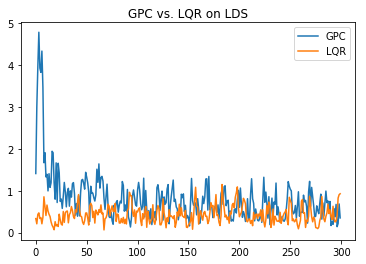

In [16]:
plt.plot([np.linalg.norm(i) for i in GPC_results], label = "GPC")
plt.plot([np.linalg.norm(i) for i in LQR_results], label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();

## Using LQR first to get good initial K estimate

In [13]:
model = GPC()
model.initialize(problem.A, problem.B, x, n, m, 3, 30, K)